original code: https://www.kaggle.com/bertcarremans/data-preparation-exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [2]:
#Load data sets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
#Describe train data
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Column naming rules of this data.    

ps_[variable]\_[number]\_[feature type]
- *bin*: binary features
- *cat*: categorial features
- Column names without this prefixes are either cotinuous or ordinal
- -1: the feature is missing from the observation

In [4]:
#Check the data size
print(f"train size:{train.shape}")
print(f"test size:{test.shape}")

train size:(595212, 59)
test size:(892816, 58)


- We are missing one variable in the test set, but this is the target variable.

In [5]:
#Check the train data information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

- No null values are present in the data set.
- Because missing values are replaced by -1. 

### Metadata
- Create Metadata data frame: this will be helpful to select specific variable later
- Metadata include
    - role: 'input', 'ID', 'target'
    - level: 'nominal', 'interval', 'ordinal', 'binary'
    - keep: True or False
    - dtype: 'int', 'float', 'str'

In [6]:
data = []
for f in train.columns:
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    keep = True
    if f == 'id':
        keep = False
    
    dtype = train[f].dtype
    
    f_dict = {'varname': f,
              'role': role,
              'level': level,
              'keep': keep,
              'dtype': dtype}
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname',
                                   'role',
                                   'level',
                                   'keep',
                                   'dtype'])

meta.set_index('varname', inplace=True)

meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


### Descriptive statistics
- Apply the describe method on the dataframe.

In [7]:
#Check the data with level 'Interval'
v = meta[(meta.level=='interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


reg variables
- *ps_reg_03* has missing values
- The range (min to max) differs between the variables.
- Could apply scaling (e.g. StandardScaler)
    - But it depends on the classifier we will want to use.
    
car variables
- *ps_car_12*, *ps_car_15* have missing values
- The range (min to max) differs between the variables.
- Could apply scaling

calc variables
- all three _calc variables have very similar distributions

In [8]:
#Check the data with level 'ordinal'
v = meta[(meta.level=='ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- *ps_car_11* has missing value
- Could apply scaling to deal with the different ranges

In [9]:
#Check the data with level 'binary'
v = meta[(meta.level=='binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- A priori in the train data is 3.645%, which is strongly imbalanced.
- Most variables the value is zero in most cases.

### Handling imbalanced classes
- At the 'binary' level, the mean is only 0.03
- To fix it we have two options
    - Oversampling records with target=1
    - Undersampling records with target=0
- Let's go with 'Undersampling'

In [10]:
#Undersampling
desired_apriori=0.10

#Indices per target value
idx_0 = train[train.target==0].index
idx_1 = train[train.target==1].index

#Number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

#Calculate undersampling rate
undersampling_rate = ((1-desired_apriori)*nb_1) / (nb_0*desired_apriori)

#Calculate resulting number of records with target=0
undersampled_nb_0 = int(undersampling_rate*nb_0)

print(f"target=0 undersmaple target rate: {undersampling_rate}")
print(f"target=0 record after undersampling: {undersampled_nb_0}")

#Random record with target=0  
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

#Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

#Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

target=0 undersmaple target rate: 0.34043569687437886
target=0 record after undersampling: 195246


### Data Quality Checks

In [11]:
#Check missing values
vars_with_missing = []

for f in train.columns:
    missings = train[train[f]==-1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        print(f"{f} \t missing_rate: {missings_perc:.2%} \t missing_count: {missings} ")

print(f"\n Total variables with missing values: {len(vars_with_missing)}")

ps_ind_02_cat 	 missing_rate: 0.05% 	 missing_count: 103 
ps_ind_04_cat 	 missing_rate: 0.02% 	 missing_count: 51 
ps_ind_05_cat 	 missing_rate: 1.04% 	 missing_count: 2256 
ps_reg_03 	 missing_rate: 17.78% 	 missing_count: 38580 
ps_car_01_cat 	 missing_rate: 0.03% 	 missing_count: 62 
ps_car_02_cat 	 missing_rate: 0.00% 	 missing_count: 2 
ps_car_03_cat 	 missing_rate: 68.39% 	 missing_count: 148367 
ps_car_05_cat 	 missing_rate: 44.26% 	 missing_count: 96026 
ps_car_07_cat 	 missing_rate: 2.04% 	 missing_count: 4431 
ps_car_09_cat 	 missing_rate: 0.11% 	 missing_count: 230 
ps_car_11 	 missing_rate: 0.00% 	 missing_count: 1 
ps_car_14 	 missing_rate: 7.25% 	 missing_count: 15726 

 Total variables with missing values: 12


In [12]:
#Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop),'keep'] = False 

#Imputing with the mean or mode
mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

In [13]:
#Check cardinality
#We will create dummy variables later -> Need to know are the values variabe
v = meta[(meta.level=='nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print(f'{f} distinct value count: {dist_values}')



ps_ind_02_cat distinct value count: 5
ps_ind_04_cat distinct value count: 3
ps_ind_05_cat distinct value count: 8
ps_car_01_cat distinct value count: 13
ps_car_02_cat distinct value count: 3
ps_car_04_cat distinct value count: 10
ps_car_06_cat distinct value count: 18
ps_car_07_cat distinct value count: 3
ps_car_08_cat distinct value count: 2
ps_car_09_cat distinct value count: 6
ps_car_10_cat distinct value count: 3
ps_car_11_cat distinct value count: 104


- ps_car_11_cat has many distinct values

In [14]:
#Script by https://www.kaggle.com/ogrellier
#Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [15]:
train_encoded, test_encoded = target_encode(train['ps_car_11_cat'], test['ps_car_11_cat'],
                                           target=train.target,
                                           min_samples_leaf=100,
                                           smoothing=10,
                                           noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)

#Update meta
meta.loc['ps_car_11_cat','keep'] = False

test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

### Exploratory Data Visualization

<Figure size 640x480 with 0 Axes>

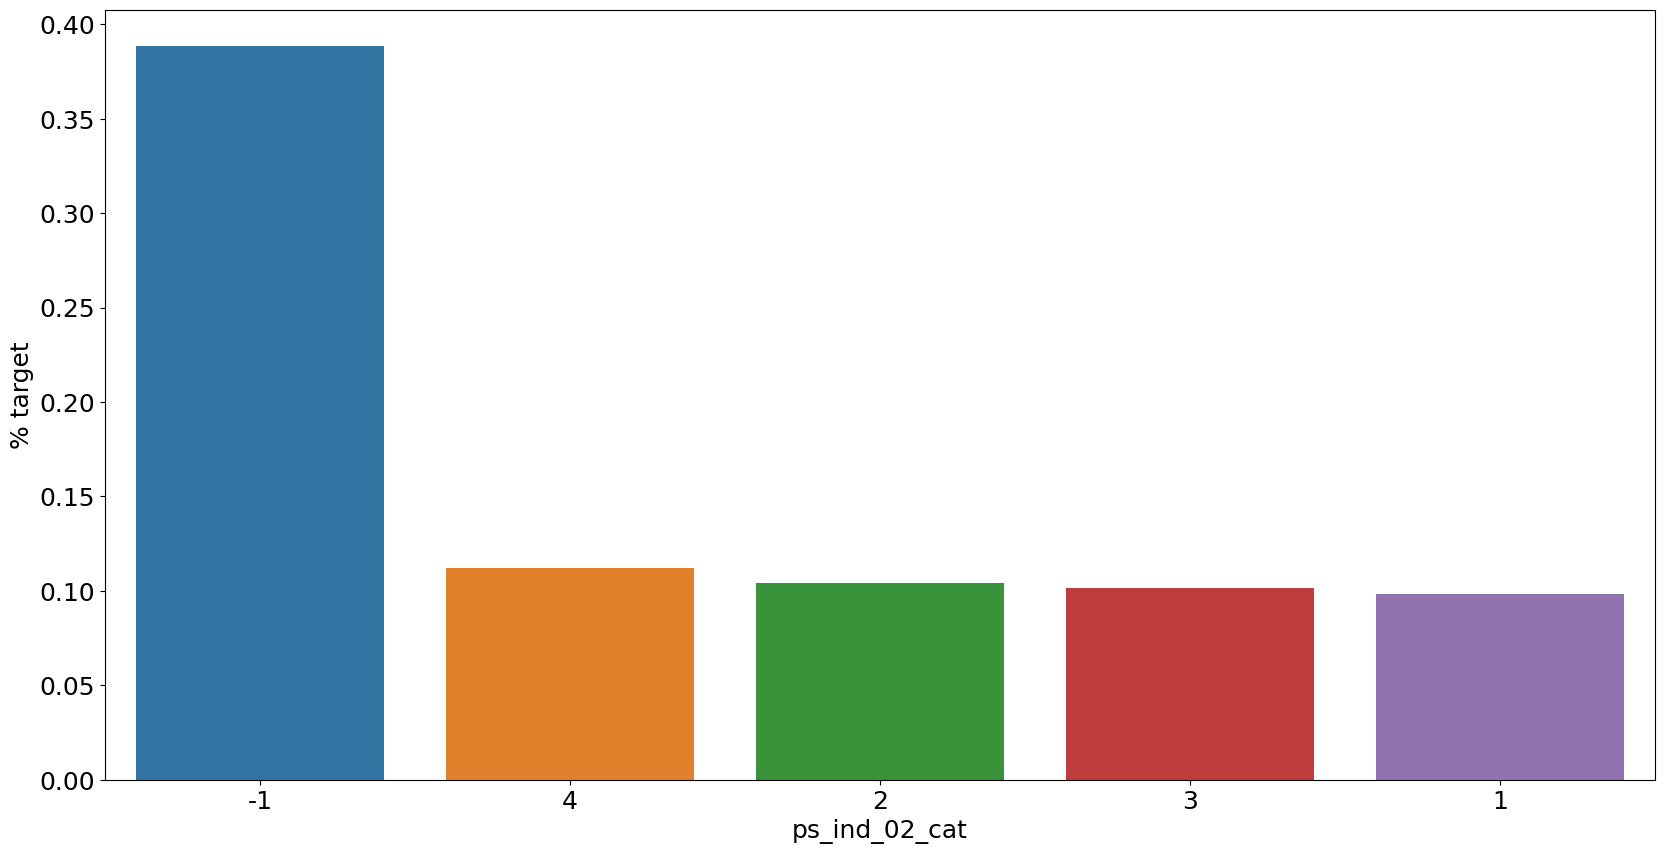

<Figure size 640x480 with 0 Axes>

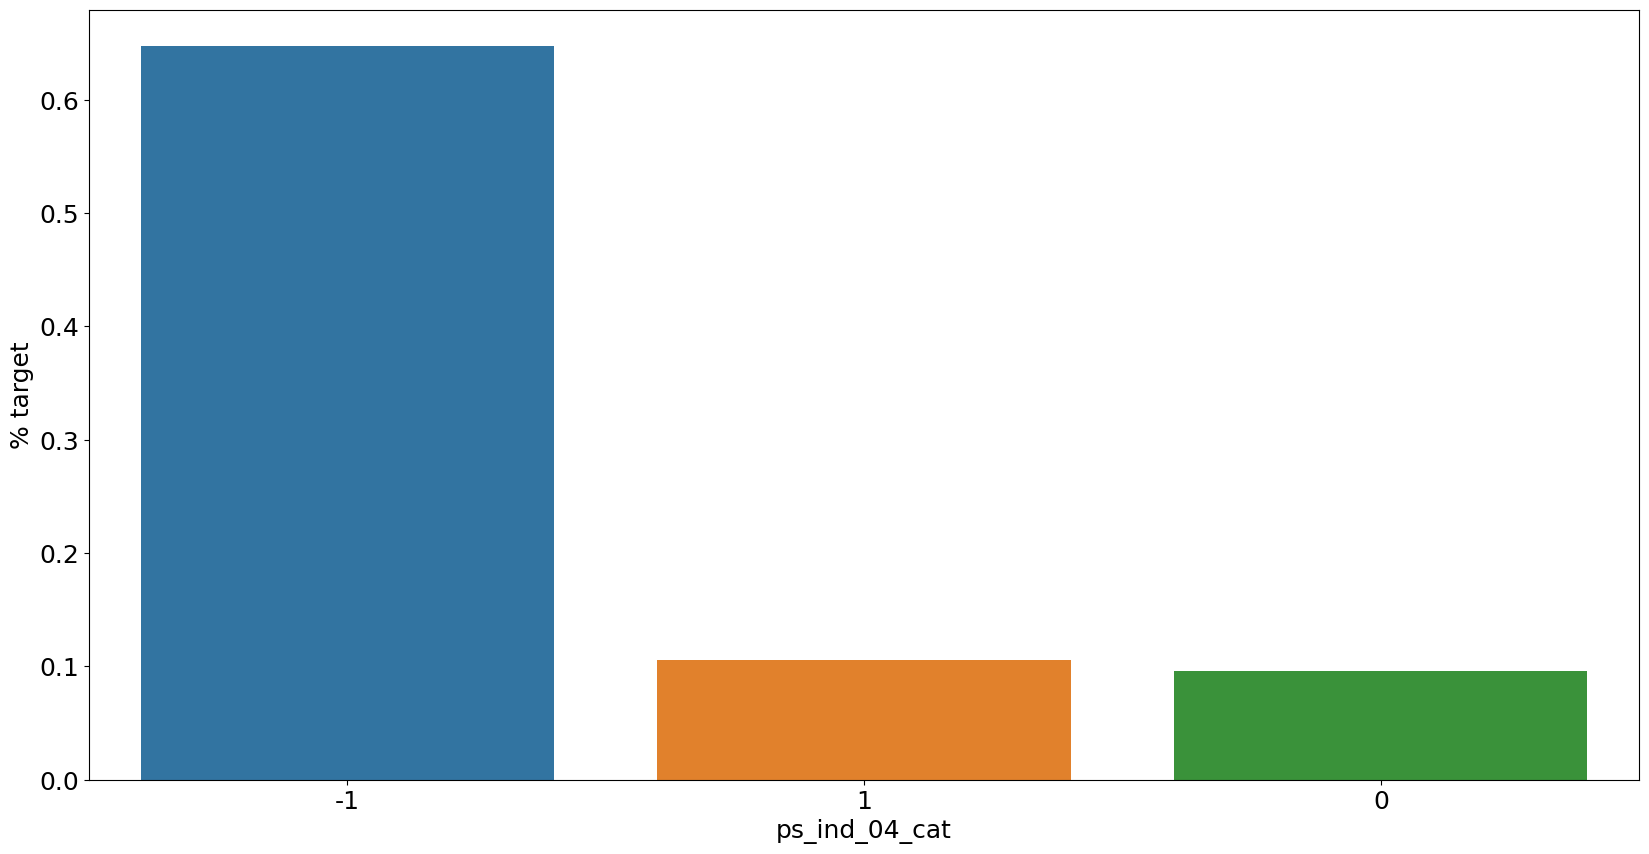

<Figure size 640x480 with 0 Axes>

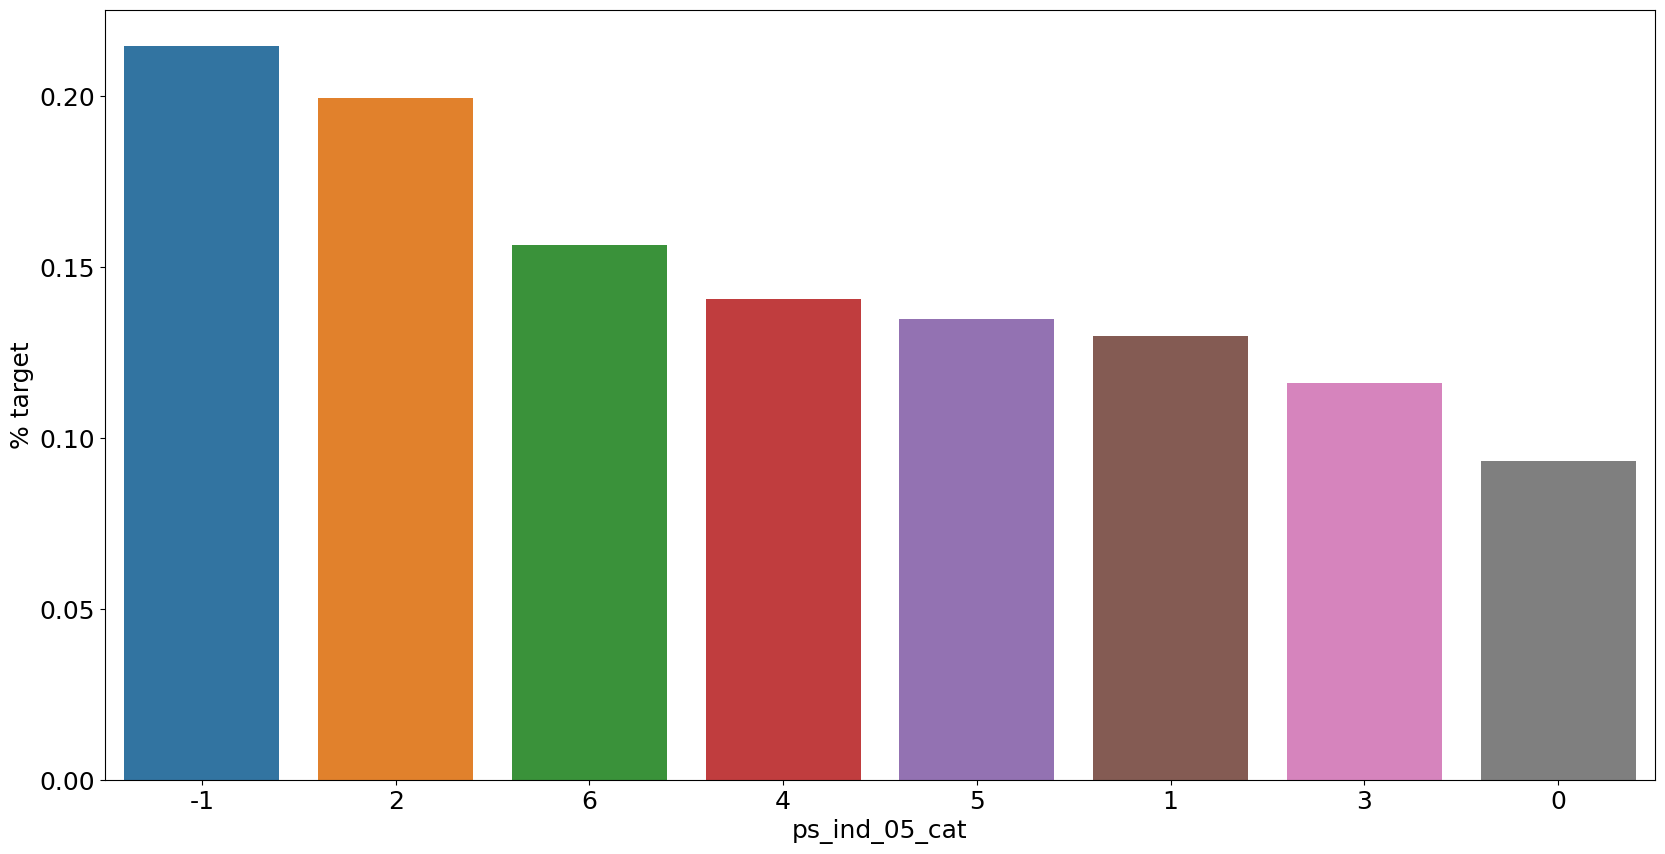

<Figure size 640x480 with 0 Axes>

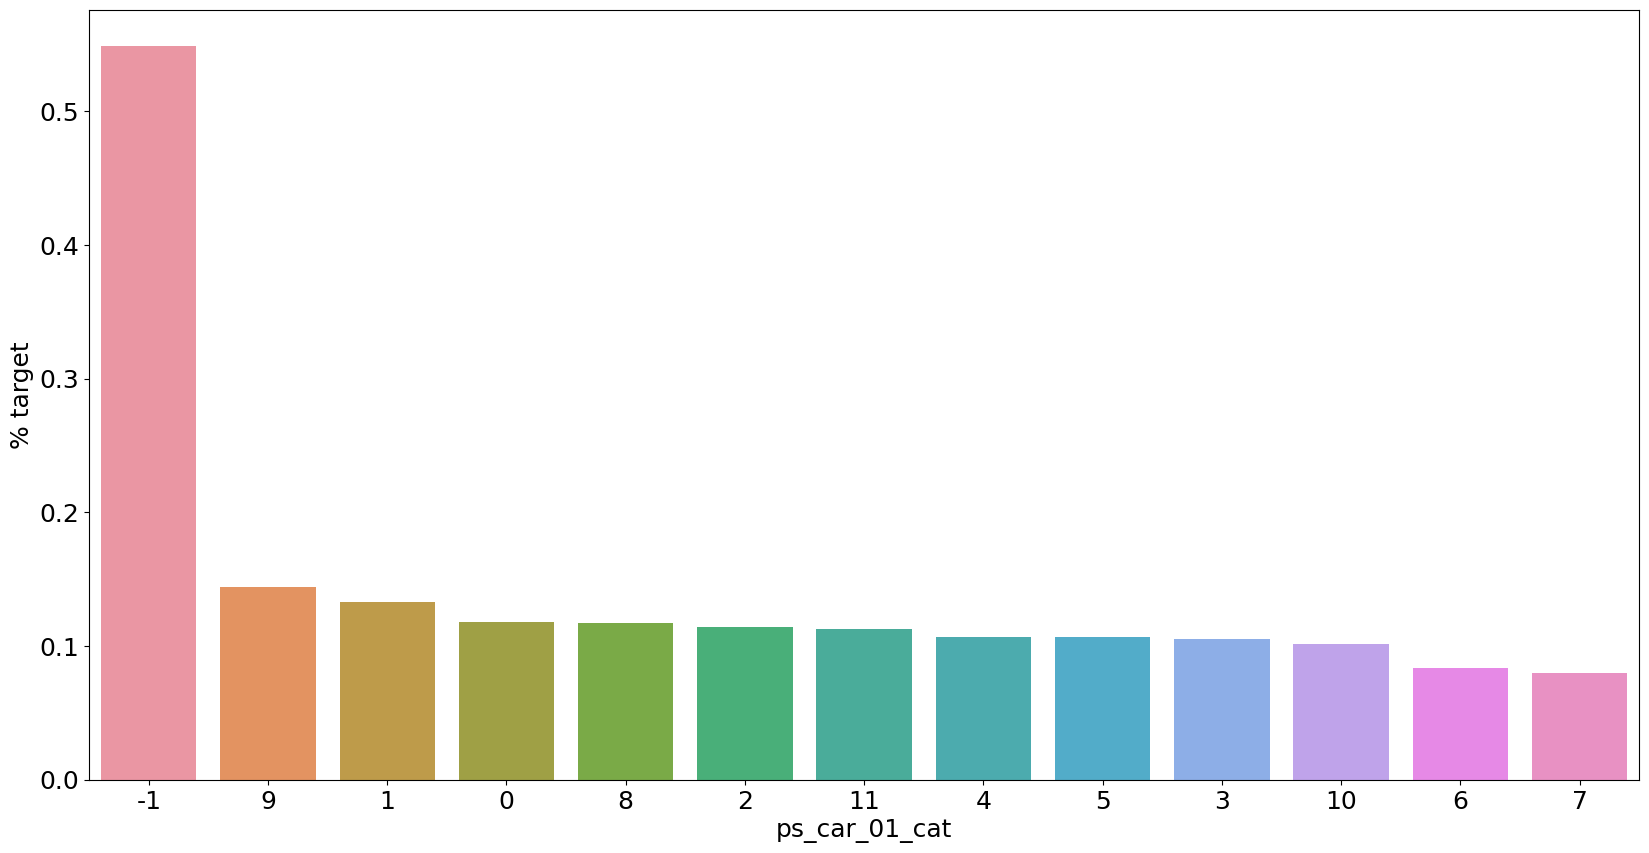

<Figure size 640x480 with 0 Axes>

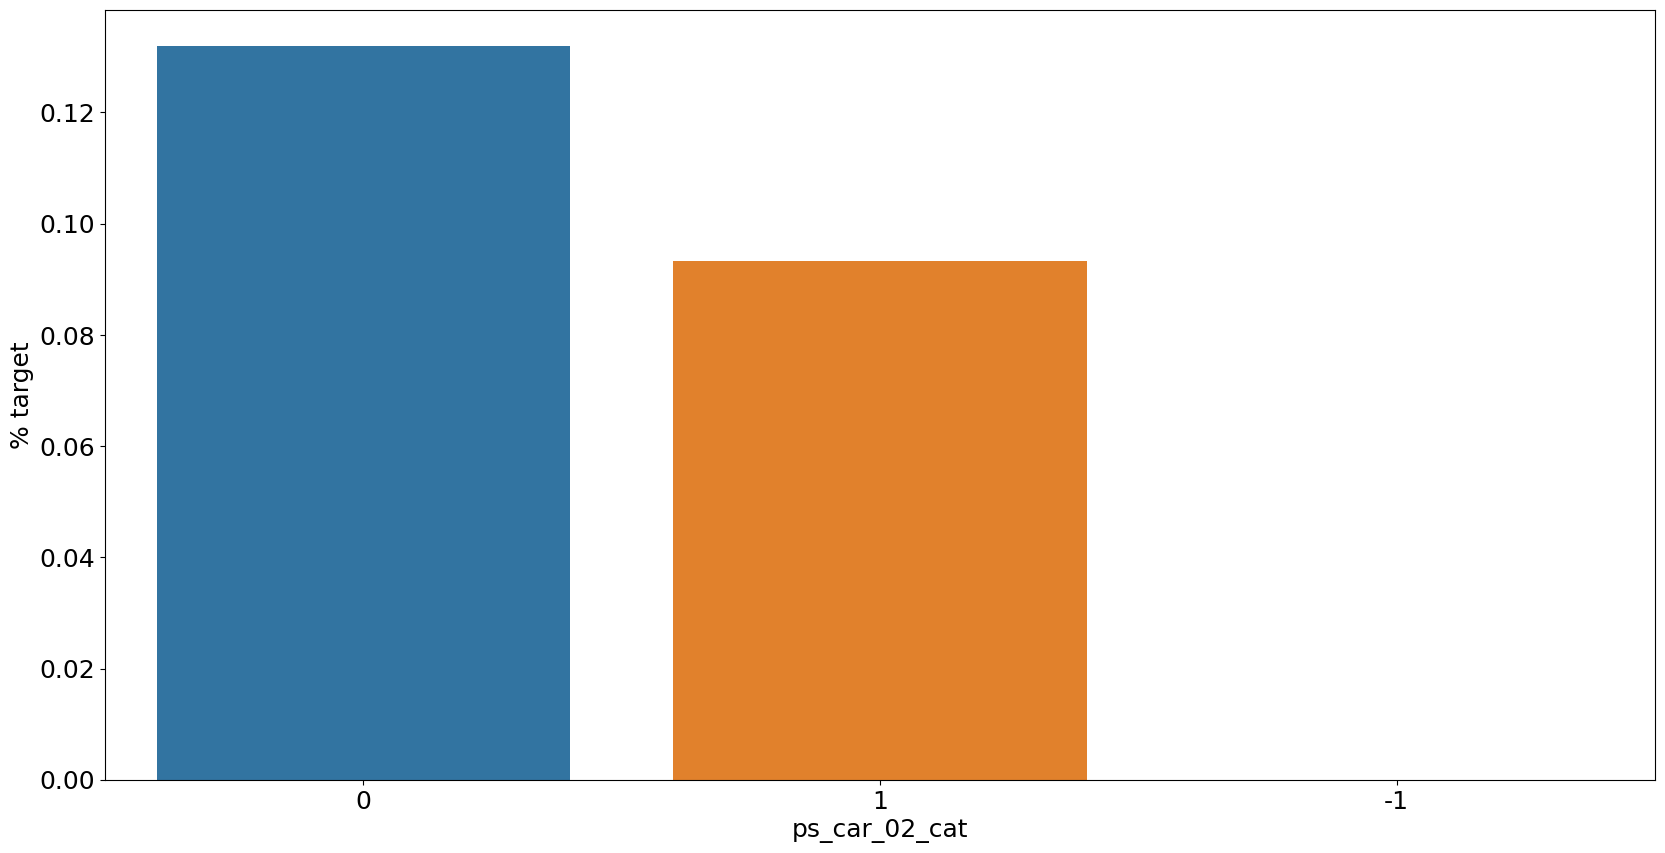

<Figure size 640x480 with 0 Axes>

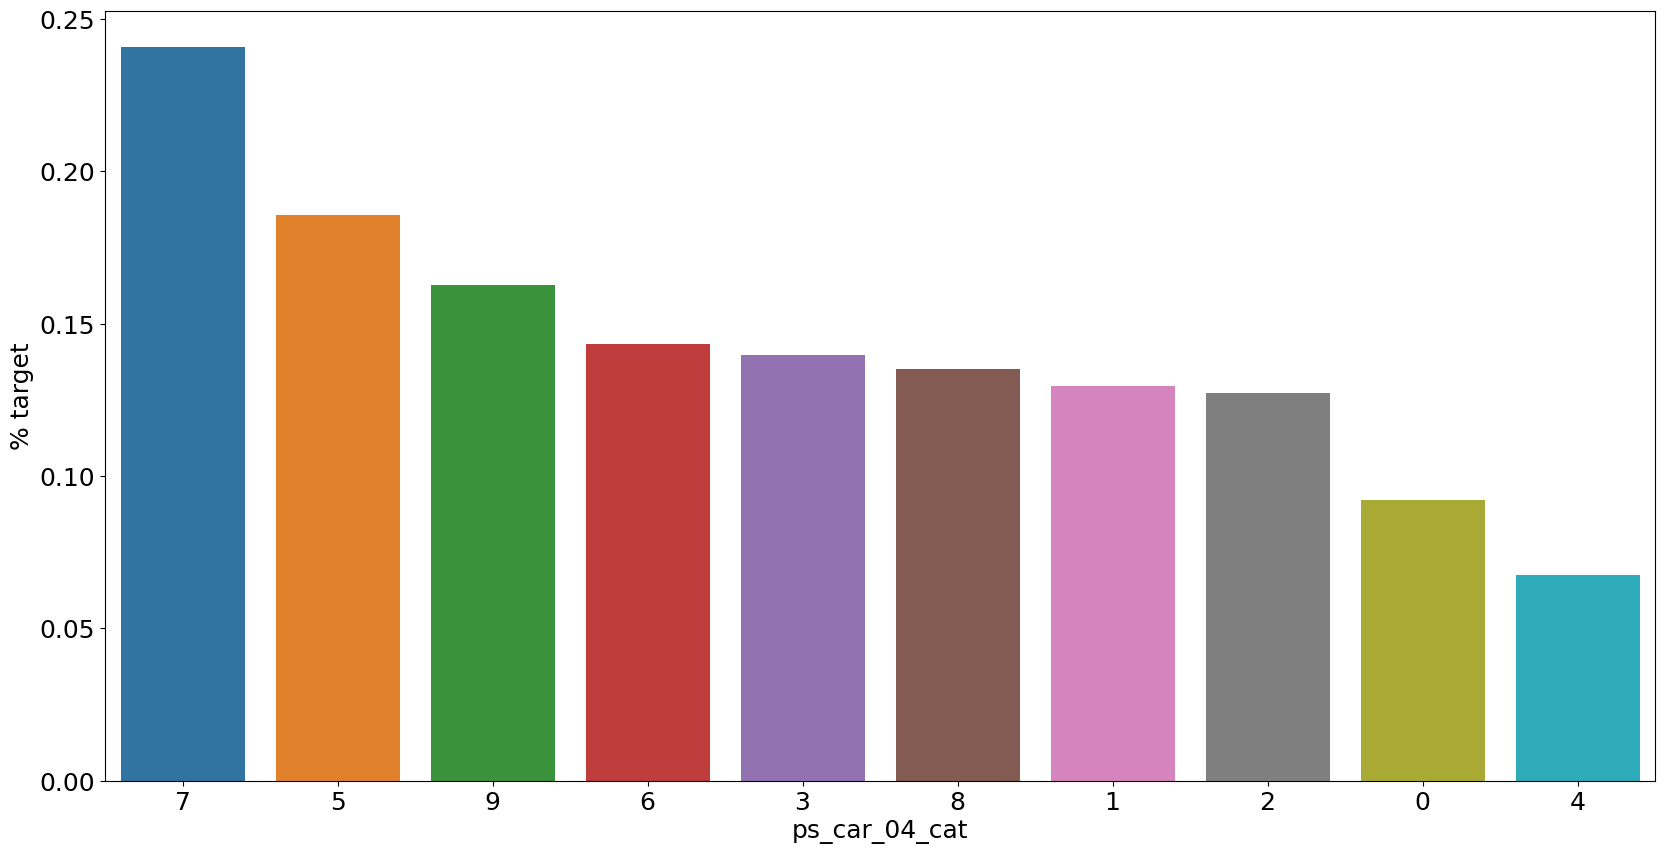

<Figure size 640x480 with 0 Axes>

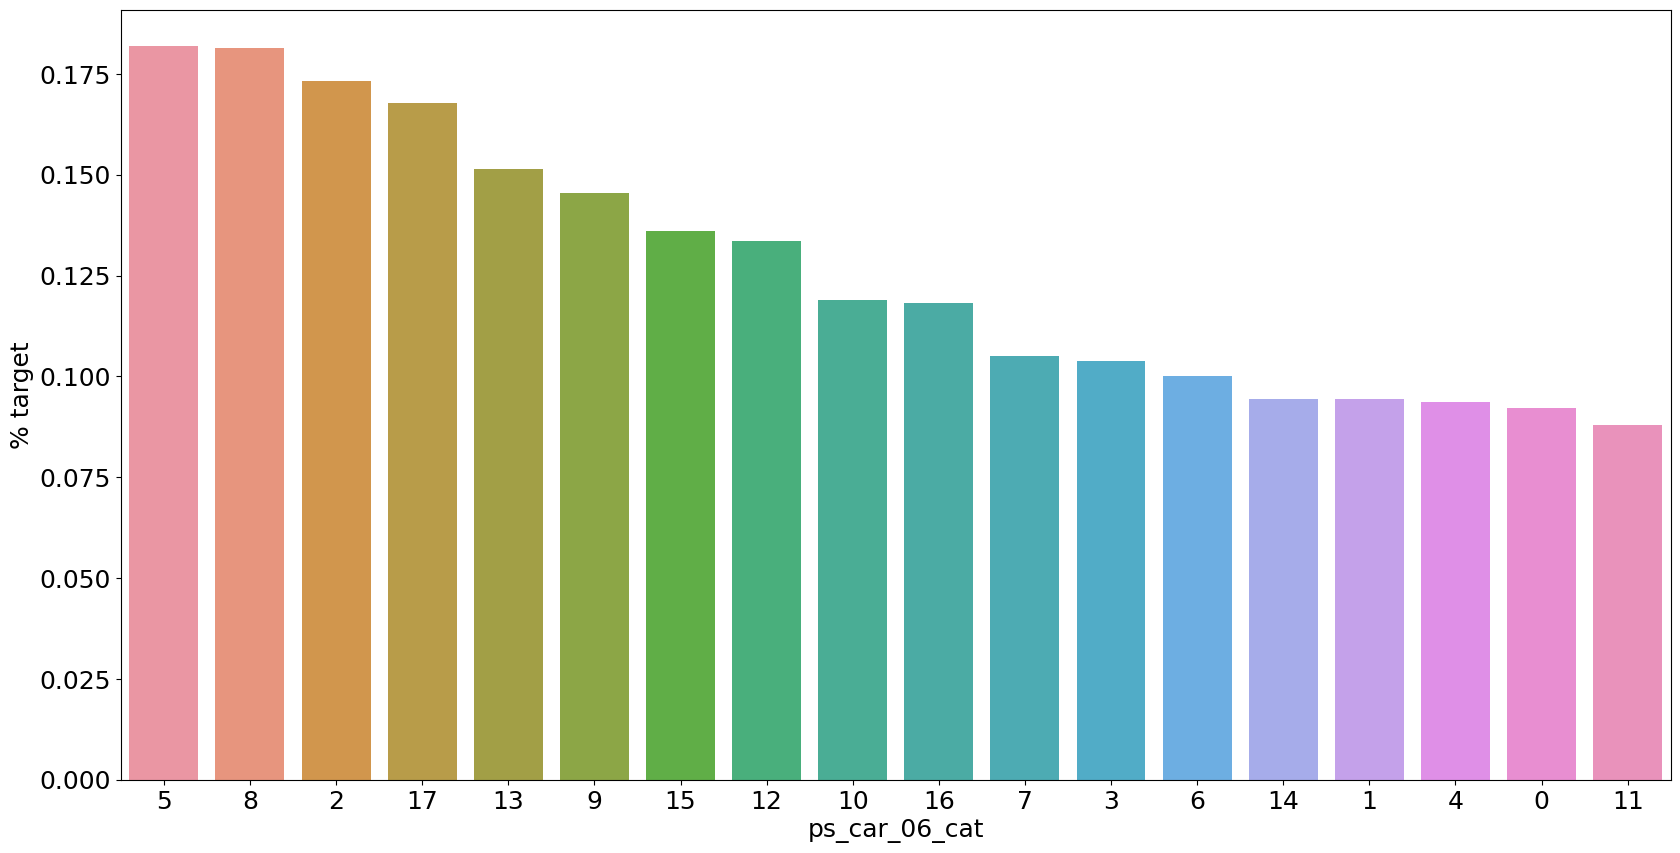

<Figure size 640x480 with 0 Axes>

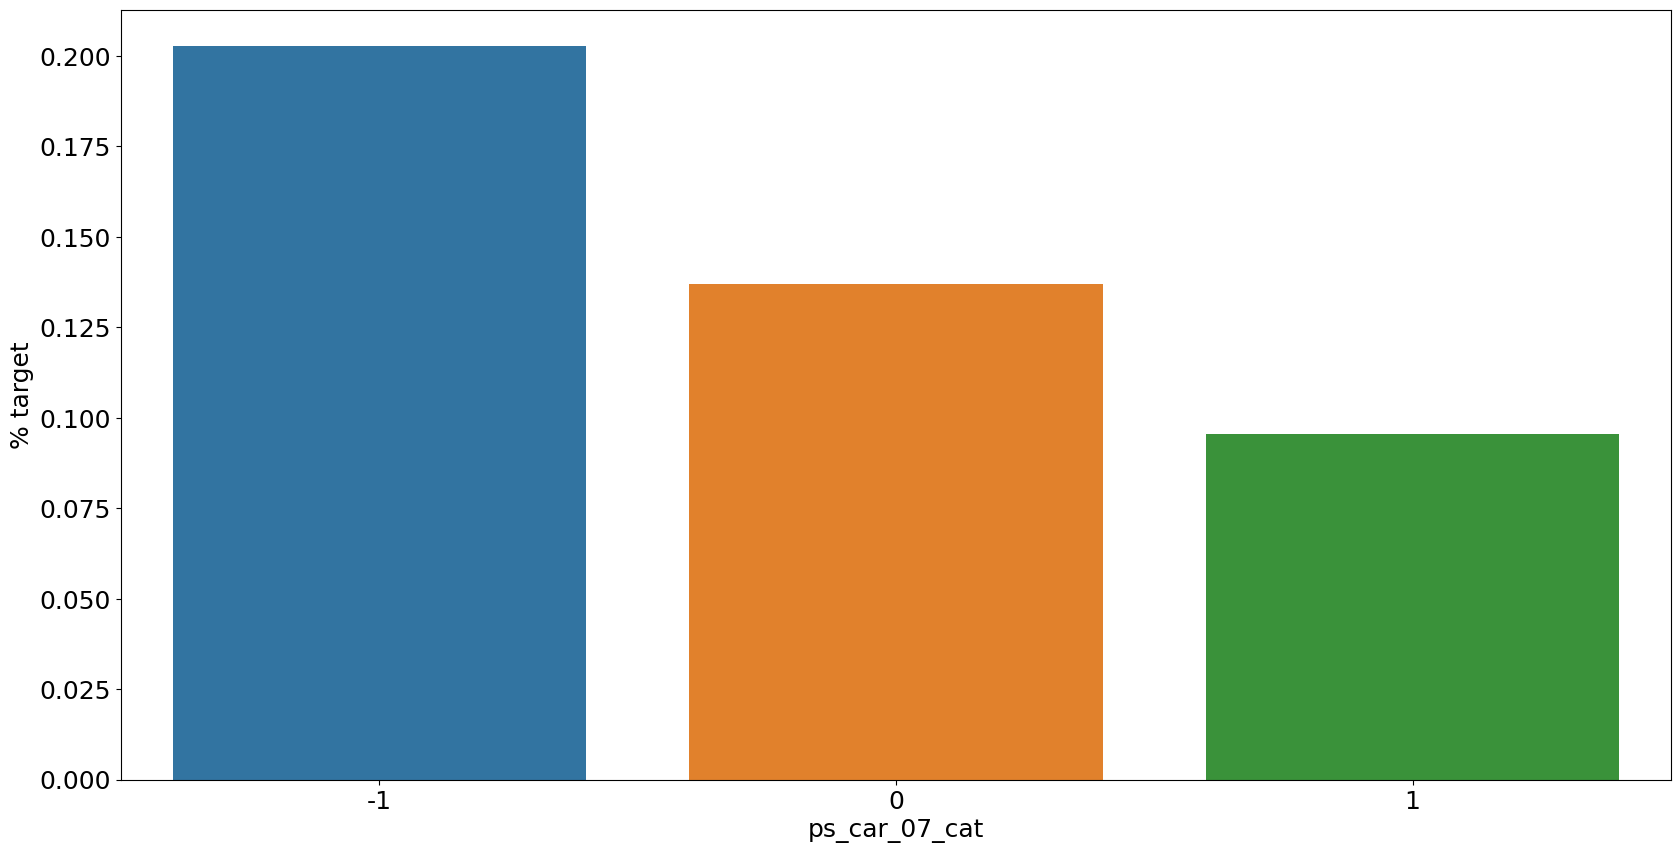

<Figure size 640x480 with 0 Axes>

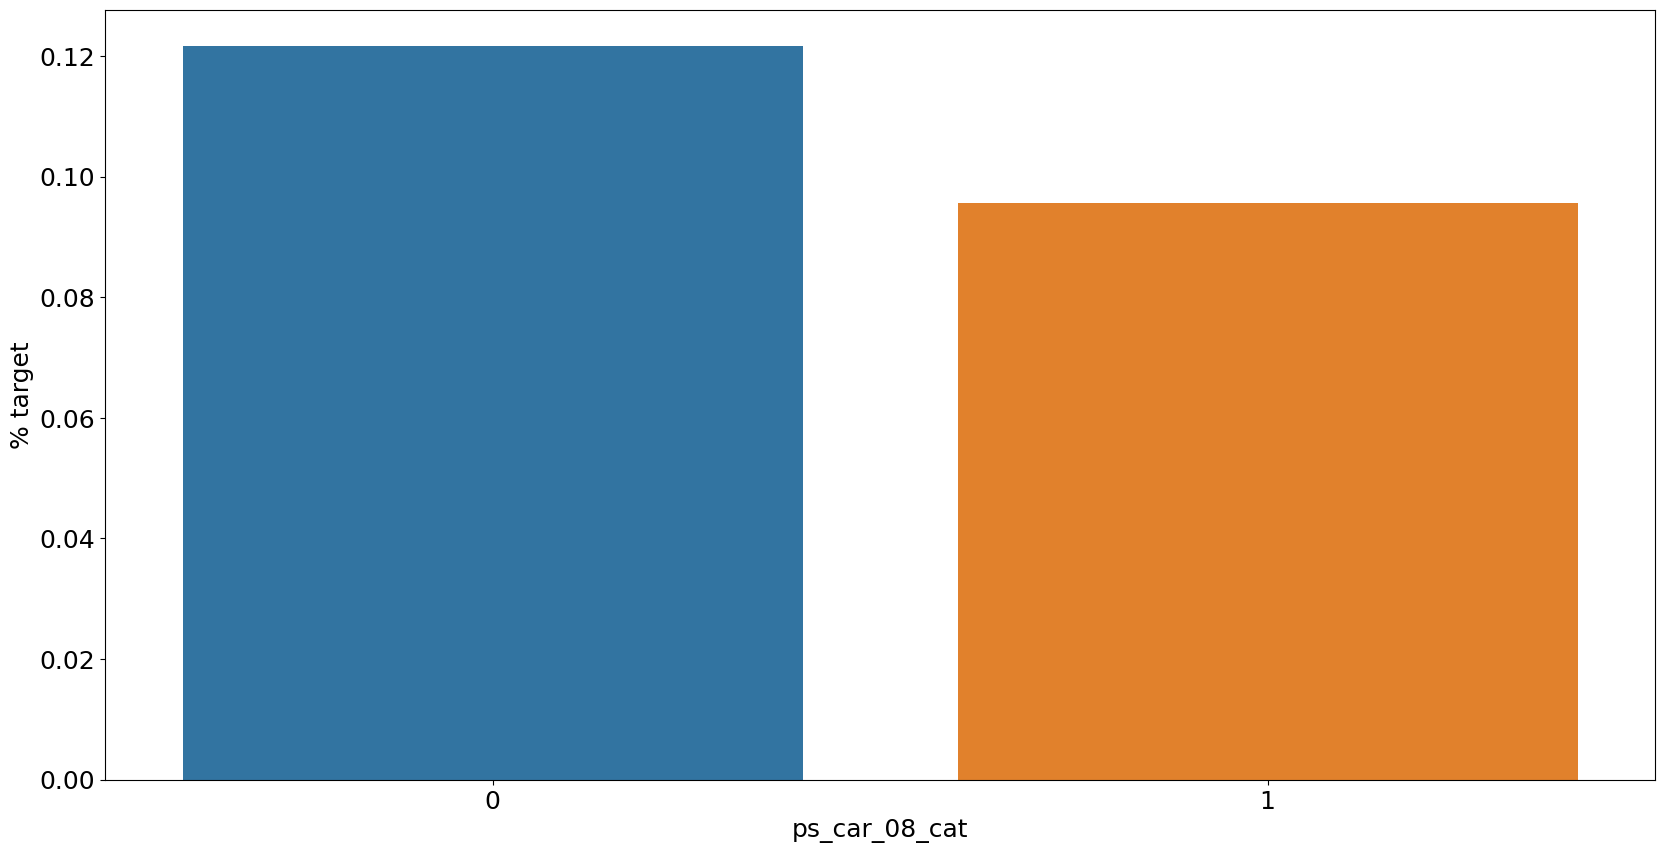

<Figure size 640x480 with 0 Axes>

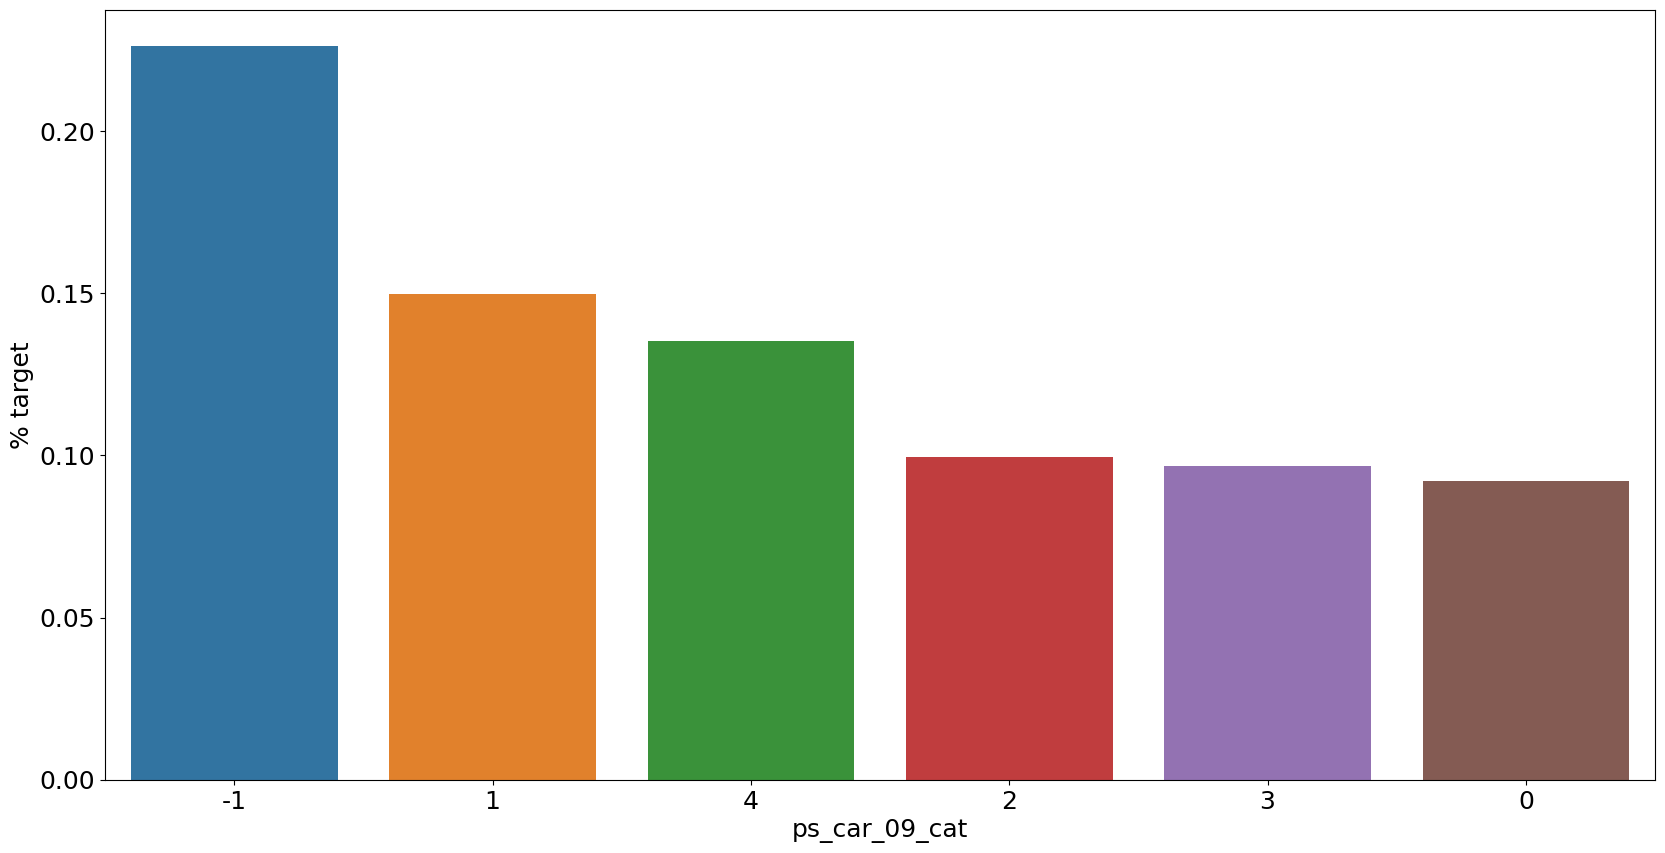

<Figure size 640x480 with 0 Axes>

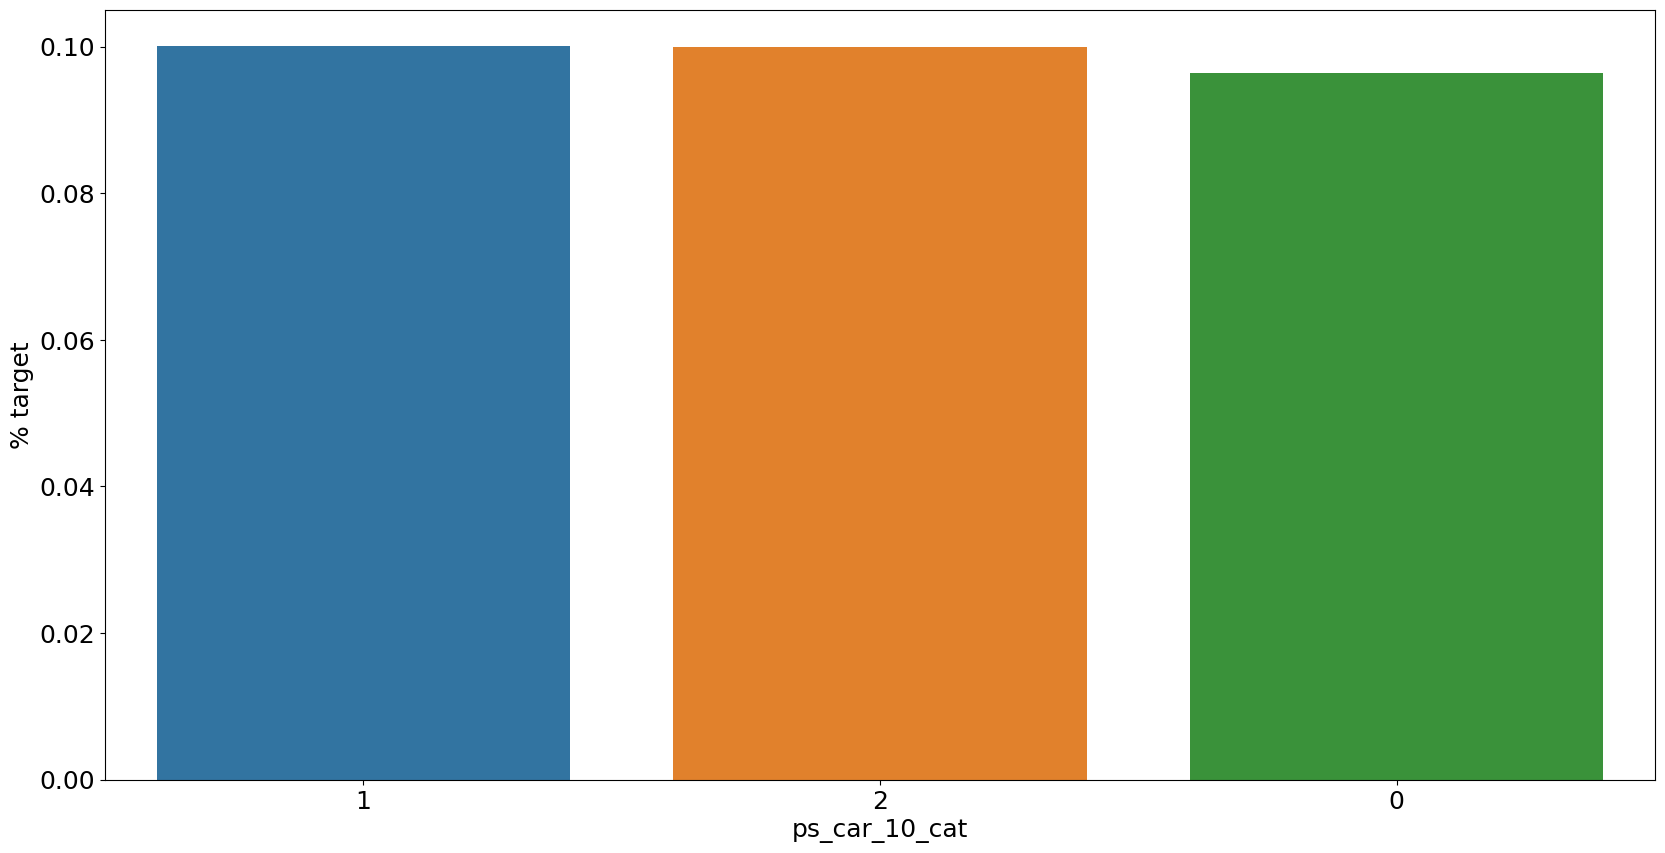

In [16]:
#Visualize categorical variables
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    
    fig, ax = plt.subplots(figsize=(20,10))
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    plt.show()

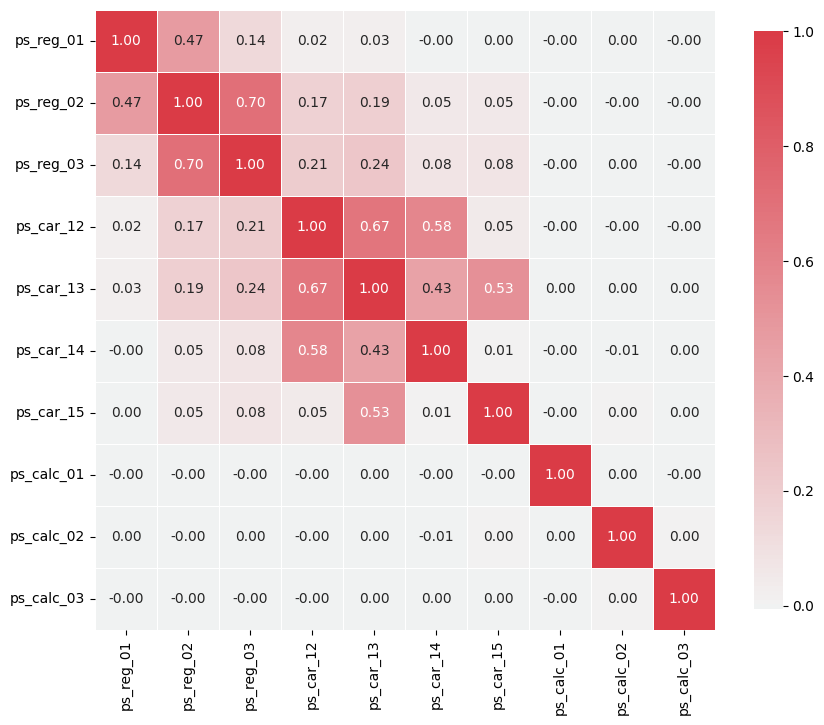

In [17]:
#Visualize interval variables
#Using correaltion heatmap

def corr_heatmap(v):
    correlations = train[v].corr()
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    
    plt.show()
    
v = meta[(meta.level=='interval') & (meta.keep)].index

corr_heatmap(v)

Strong correlations between the variables
- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)

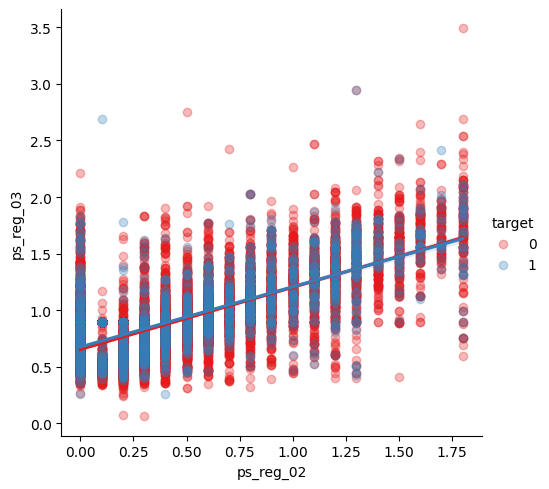

In [18]:
#Visualize the strong correlation variables: ps_reg_02 & ps_reg_03
#Use small fractures of the data
s = train.sample(frac=0.1)
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

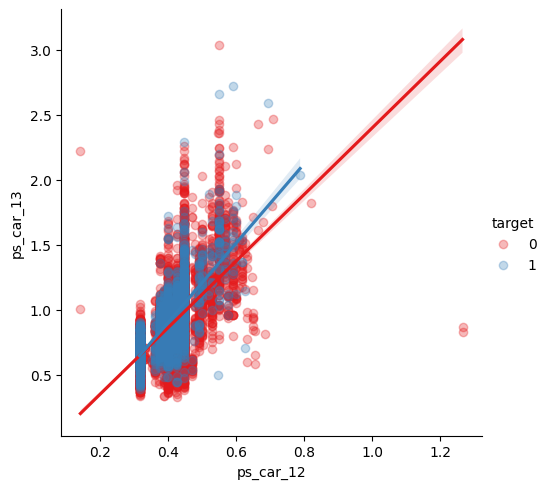

In [19]:
#Visualize the strong correlation variables: ps_car_12 & ps_car_13
#Use small fractures of the data
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

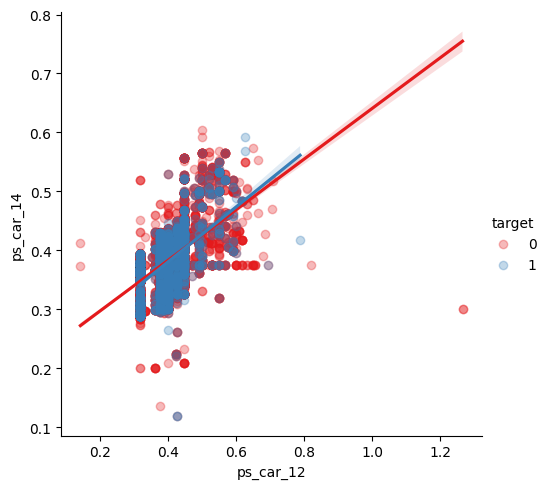

In [20]:
#Visualize the strong correlation variables: ps_car_12 & ps_car_14
#Use small fractures of the data
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

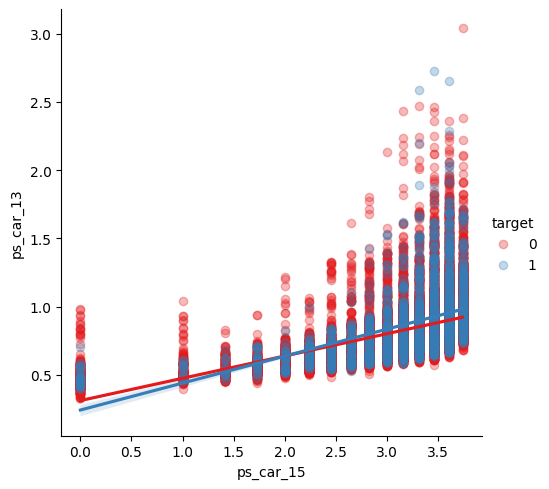

In [21]:
#Visualize the strong correlation variables: ps_car_13 & ps_car_15
#Use small fractures of the data
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

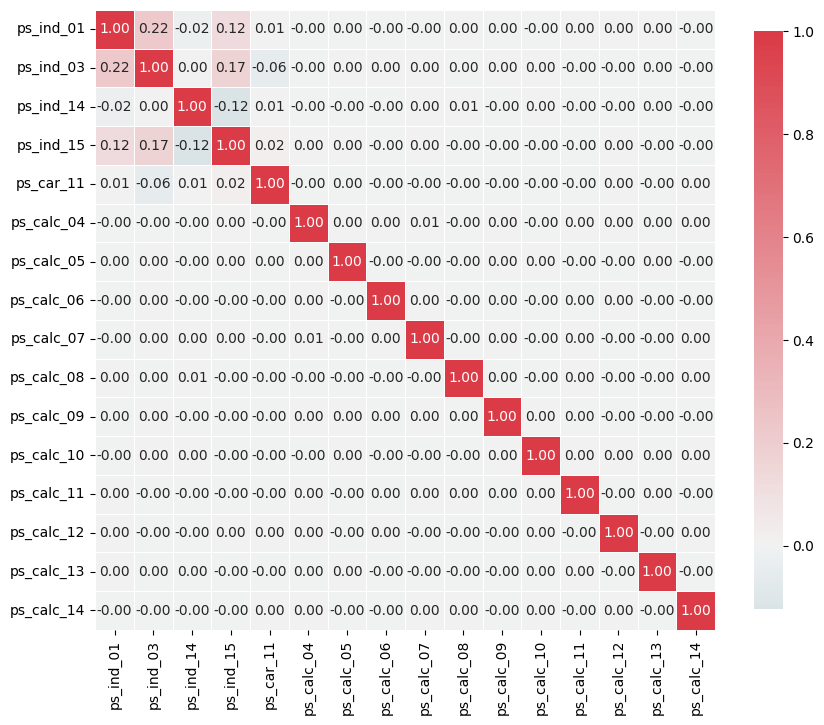

In [22]:
#Visualize ordinal level variables
v = meta[(meta.level == 'ordinal')&(meta.keep)].index
corr_heatmap(v)

### Feature engineering

In [23]:
#Create dummy variables for the categorical variables
v = meta[(meta.level == 'nominal')&(meta.keep)].index
print(f'Variables count before dummy:{train.shape[1]}')

train = pd.get_dummies(train, columns=v, drop_first=True)
print(f'Variables count after dummy:{train.shape[1]}')

Variables count before dummy:57
Variables count after dummy:109


In [24]:
#Create interaction variables
v = meta[(meta.level=='interval')&(meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
interactions.drop(v, axis=1, inplace=True)

#Merge interaction variables and the train data
print(f'variable counts bbefore merege: {train.shape[1]}')

train = pd.concat([train, interactions], axis=1)
print(f'variable counts after merge: {train.shape[1]}')

variable counts bbefore merege: 109
variable counts after merge: 164


### Feature selection

In [25]:
#Remove low or zero variance features
#Set the variance threshold: 0.01
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1))

f = np.vectorize(lambda x : not x) 
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print(f'Low variance variables count: {len(v)}')

Low variance variables count: 28


- We would lose rather many variables if we would select based on variance.
- But because we do not have so many variables, we'll let the classifier chose.

In [26]:
#Select features with RandomForest and SelectFromModel
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print(f"{f+1} {feat_labels[indices[f]]} \t {importances[indices[f]]}")

1 ps_car_11_cat_te 	 0.021212818425535903
2 ps_car_13 	 0.017381571816333506
3 ps_car_12 ps_car_13 	 0.01720724656796091
4 ps_car_13^2 	 0.01719424104382184
5 ps_car_13 ps_car_14 	 0.017111155666219662
6 ps_reg_03 ps_car_13 	 0.017108495725983507
7 ps_car_13 ps_car_15 	 0.01686020948709959
8 ps_reg_01 ps_car_13 	 0.016836582625158632
9 ps_reg_03 ps_car_14 	 0.016298163787858835
10 ps_reg_03 ps_car_12 	 0.015553651474437307
11 ps_reg_03 ps_car_15 	 0.015093724700680038
12 ps_car_14 ps_car_15 	 0.015044406553503524
13 ps_car_13 ps_calc_01 	 0.01474281792544114
14 ps_reg_01 ps_reg_03 	 0.014718894201566227
15 ps_car_13 ps_calc_02 	 0.014681183849444368
16 ps_car_13 ps_calc_03 	 0.014675357478665437
17 ps_reg_02 ps_car_13 	 0.014610601852803034
18 ps_reg_01 ps_car_14 	 0.014365258181473807
19 ps_reg_03^2 	 0.014257992750481337
20 ps_reg_03 	 0.01422221327026433
21 ps_reg_03 ps_calc_03 	 0.013793586576062779
22 ps_reg_03 ps_calc_02 	 0.013787099285852785
23 ps_reg_03 ps_calc_01 	 0.01377193

In [27]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)

print(f"Features before selection: {X_train.shape[1]}")

n_features = sfm.transform(X_train).shape[1]
print(f"Features after selection: {n_features}")
selected_vars = list(feat_labels[sfm.get_support()])

Features before selection: 162


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Features after selection: 81


In [28]:
train = train[selected_vars + ['target']]

### Features scaling

In [29]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])